# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [11]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

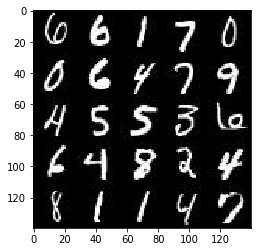

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

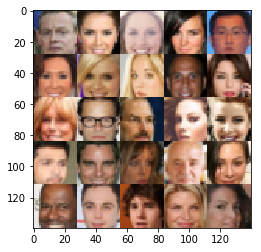

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [15]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_image = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels],name='real_image')
    fake_image = tf.placeholder(tf.float32, [None, z_dim] ,name='fake_image')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')


    return real_image, fake_image, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#mark_used()
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # layer1[14,14,64] 

        layer1 = tf.layers.conv2d(images, 64, 5, strides=2,padding='same')
        layer1 = tf.maximum(alpha*layer1,layer1)
        
        # layer2[8,8,128] 
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2,padding='same')
        layer2 = tf.layers.batch_normalization(layer2,training=True)
        layer2 = tf.maximum(alpha*layer2,layer2)

        # layer3[4,4,256] 
        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=2,padding='same')
        layer3 = tf.layers.batch_normalization(layer3,training=True)
        layer3 = tf.maximum(alpha*layer3,layer3)
        
        flatten = tf.reshape(layer3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        out = tf.nn.sigmoid(logits)

        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        
        # layer1, 7,7,512 
        layer1 = tf.layers.dense(z, 7*7*512)
        layer1 = tf.reshape(layer1, (-1,7,7,512))
        layer1 = tf.layers.batch_normalization(layer1,training=is_train)
        layer1 = tf.maximum(layer1*alpha, layer1)
        
        #layer2 7,7,256 
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5,strides=1,padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha*layer2, layer2)
        
        #layer3 14,14,128 
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5,strides=2,padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha*layer3, layer3)
        
        #outlayer 28,28, out
        layer4 = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=2, padding='SAME')
        
        out = tf.tanh(layer4)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim,alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_logits_real)*alpha))
        
    fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_logits_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_logits_fake)))
    
    d_loss = fake_loss + real_loss

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    varis = tf.trainable_variables()
    
    d_vars = [var for var in varis if (var.name.startswith('discriminator'))]
    g_vars = [var for var in varis if (var.name.startswith('generator'))]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_fake, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_fake, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_fake: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_fake: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_fake: batch_z})
                    train_loss_g = g_loss.eval({input_fake: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_fake, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 3.7251... Generator Loss: 0.3284
Epoch 1/2... Batch 20... Discriminator Loss: 1.9135... Generator Loss: 2.0749
Epoch 1/2... Batch 30... Discriminator Loss: 0.9460... Generator Loss: 1.5848
Epoch 1/2... Batch 40... Discriminator Loss: 2.3672... Generator Loss: 7.6032
Epoch 1/2... Batch 50... Discriminator Loss: 0.7698... Generator Loss: 2.5914
Epoch 1/2... Batch 60... Discriminator Loss: 2.2462... Generator Loss: 0.2725
Epoch 1/2... Batch 70... Discriminator Loss: 1.1247... Generator Loss: 1.4712
Epoch 1/2... Batch 80... Discriminator Loss: 1.7551... Generator Loss: 0.3589
Epoch 1/2... Batch 90... Discriminator Loss: 1.8957... Generator Loss: 0.2992
Epoch 1/2... Batch 100... Discriminator Loss: 0.9860... Generator Loss: 1.2203


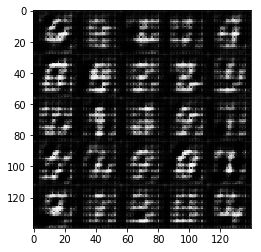

Epoch 1/2... Batch 110... Discriminator Loss: 1.4446... Generator Loss: 2.0748
Epoch 1/2... Batch 120... Discriminator Loss: 1.3497... Generator Loss: 0.6224
Epoch 1/2... Batch 130... Discriminator Loss: 1.5468... Generator Loss: 0.5053
Epoch 1/2... Batch 140... Discriminator Loss: 1.2008... Generator Loss: 0.8614
Epoch 1/2... Batch 150... Discriminator Loss: 1.4564... Generator Loss: 0.6360
Epoch 1/2... Batch 160... Discriminator Loss: 1.3448... Generator Loss: 0.6694
Epoch 1/2... Batch 170... Discriminator Loss: 1.2165... Generator Loss: 1.4698
Epoch 1/2... Batch 180... Discriminator Loss: 1.1636... Generator Loss: 0.7808
Epoch 1/2... Batch 190... Discriminator Loss: 1.2639... Generator Loss: 0.7536
Epoch 1/2... Batch 200... Discriminator Loss: 1.4900... Generator Loss: 0.5387


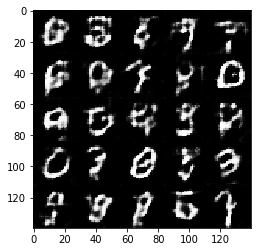

Epoch 1/2... Batch 210... Discriminator Loss: 1.5874... Generator Loss: 0.4490
Epoch 1/2... Batch 220... Discriminator Loss: 1.3807... Generator Loss: 1.4445
Epoch 1/2... Batch 230... Discriminator Loss: 1.8426... Generator Loss: 2.5070
Epoch 1/2... Batch 240... Discriminator Loss: 1.5368... Generator Loss: 2.1879
Epoch 1/2... Batch 250... Discriminator Loss: 1.7015... Generator Loss: 0.3895
Epoch 1/2... Batch 260... Discriminator Loss: 1.2758... Generator Loss: 1.3542
Epoch 1/2... Batch 270... Discriminator Loss: 1.8471... Generator Loss: 0.3069
Epoch 1/2... Batch 280... Discriminator Loss: 1.0734... Generator Loss: 1.0305
Epoch 1/2... Batch 290... Discriminator Loss: 1.2737... Generator Loss: 0.7483
Epoch 1/2... Batch 300... Discriminator Loss: 1.3735... Generator Loss: 1.3730


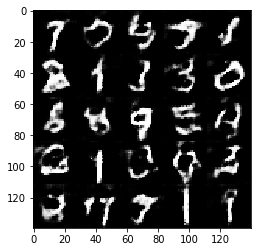

Epoch 1/2... Batch 310... Discriminator Loss: 2.0076... Generator Loss: 0.2540
Epoch 1/2... Batch 320... Discriminator Loss: 1.2020... Generator Loss: 0.8493
Epoch 1/2... Batch 330... Discriminator Loss: 1.2341... Generator Loss: 1.0221
Epoch 1/2... Batch 340... Discriminator Loss: 1.2619... Generator Loss: 1.4405
Epoch 1/2... Batch 350... Discriminator Loss: 1.4947... Generator Loss: 0.5080
Epoch 1/2... Batch 360... Discriminator Loss: 1.2716... Generator Loss: 0.6809
Epoch 1/2... Batch 370... Discriminator Loss: 1.1903... Generator Loss: 1.4016
Epoch 1/2... Batch 380... Discriminator Loss: 1.3319... Generator Loss: 0.6903
Epoch 1/2... Batch 390... Discriminator Loss: 1.2174... Generator Loss: 0.9867
Epoch 1/2... Batch 400... Discriminator Loss: 1.1846... Generator Loss: 0.9754


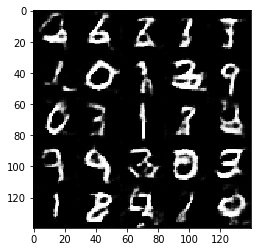

Epoch 1/2... Batch 410... Discriminator Loss: 1.2829... Generator Loss: 0.7270
Epoch 1/2... Batch 420... Discriminator Loss: 1.3332... Generator Loss: 0.6503
Epoch 1/2... Batch 430... Discriminator Loss: 1.1929... Generator Loss: 1.0918
Epoch 1/2... Batch 440... Discriminator Loss: 1.4406... Generator Loss: 0.4929
Epoch 1/2... Batch 450... Discriminator Loss: 1.3137... Generator Loss: 0.6177
Epoch 1/2... Batch 460... Discriminator Loss: 1.2712... Generator Loss: 0.7507
Epoch 2/2... Batch 10... Discriminator Loss: 1.2558... Generator Loss: 1.6464
Epoch 2/2... Batch 20... Discriminator Loss: 1.4291... Generator Loss: 0.5549
Epoch 2/2... Batch 30... Discriminator Loss: 1.2737... Generator Loss: 1.2065
Epoch 2/2... Batch 40... Discriminator Loss: 1.1549... Generator Loss: 0.9804
Epoch 2/2... Batch 50... Discriminator Loss: 1.3643... Generator Loss: 0.6066
Epoch 2/2... Batch 60... Discriminator Loss: 1.3747... Generator Loss: 1.5456
Epoch 2/2... Batch 70... Discriminator Loss: 1.4044... Gen

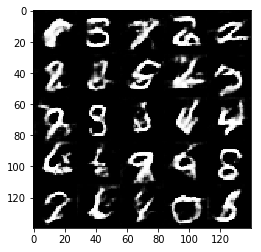

Epoch 2/2... Batch 110... Discriminator Loss: 1.2546... Generator Loss: 1.7916
Epoch 2/2... Batch 120... Discriminator Loss: 1.6279... Generator Loss: 0.3905
Epoch 2/2... Batch 130... Discriminator Loss: 1.1249... Generator Loss: 1.1082
Epoch 2/2... Batch 140... Discriminator Loss: 1.1623... Generator Loss: 0.8512
Epoch 2/2... Batch 150... Discriminator Loss: 1.4702... Generator Loss: 0.4890
Epoch 2/2... Batch 160... Discriminator Loss: 1.1970... Generator Loss: 1.0815
Epoch 2/2... Batch 170... Discriminator Loss: 1.2632... Generator Loss: 0.6777
Epoch 2/2... Batch 180... Discriminator Loss: 1.2459... Generator Loss: 0.6660
Epoch 2/2... Batch 190... Discriminator Loss: 1.2314... Generator Loss: 0.7004
Epoch 2/2... Batch 200... Discriminator Loss: 1.1534... Generator Loss: 1.2086


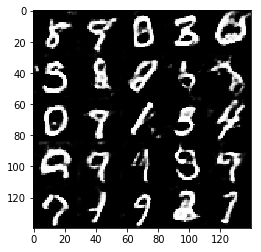

Epoch 2/2... Batch 210... Discriminator Loss: 1.3499... Generator Loss: 0.6695
Epoch 2/2... Batch 220... Discriminator Loss: 1.3132... Generator Loss: 0.6393
Epoch 2/2... Batch 230... Discriminator Loss: 1.3706... Generator Loss: 0.5757
Epoch 2/2... Batch 240... Discriminator Loss: 1.1040... Generator Loss: 1.2028
Epoch 2/2... Batch 250... Discriminator Loss: 1.0988... Generator Loss: 1.2321
Epoch 2/2... Batch 260... Discriminator Loss: 1.2194... Generator Loss: 1.1986
Epoch 2/2... Batch 270... Discriminator Loss: 1.1830... Generator Loss: 1.1649
Epoch 2/2... Batch 280... Discriminator Loss: 1.1755... Generator Loss: 1.8109
Epoch 2/2... Batch 290... Discriminator Loss: 1.2741... Generator Loss: 0.6824
Epoch 2/2... Batch 300... Discriminator Loss: 1.6619... Generator Loss: 0.4109


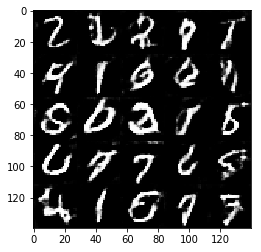

Epoch 2/2... Batch 310... Discriminator Loss: 1.3231... Generator Loss: 0.5622
Epoch 2/2... Batch 320... Discriminator Loss: 1.4718... Generator Loss: 0.5252
Epoch 2/2... Batch 330... Discriminator Loss: 1.2111... Generator Loss: 0.7859
Epoch 2/2... Batch 340... Discriminator Loss: 1.1326... Generator Loss: 0.8753
Epoch 2/2... Batch 350... Discriminator Loss: 1.1728... Generator Loss: 0.8160
Epoch 2/2... Batch 360... Discriminator Loss: 1.7089... Generator Loss: 0.3993
Epoch 2/2... Batch 370... Discriminator Loss: 1.2131... Generator Loss: 1.7976
Epoch 2/2... Batch 380... Discriminator Loss: 1.6280... Generator Loss: 0.4099
Epoch 2/2... Batch 390... Discriminator Loss: 1.2097... Generator Loss: 1.2952
Epoch 2/2... Batch 400... Discriminator Loss: 1.4250... Generator Loss: 0.5094


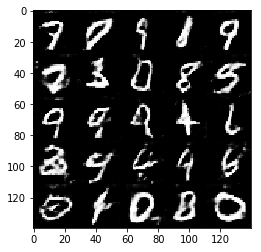

Epoch 2/2... Batch 410... Discriminator Loss: 1.1344... Generator Loss: 1.8149
Epoch 2/2... Batch 420... Discriminator Loss: 1.3989... Generator Loss: 1.8404
Epoch 2/2... Batch 430... Discriminator Loss: 1.2688... Generator Loss: 0.6333
Epoch 2/2... Batch 440... Discriminator Loss: 2.0292... Generator Loss: 0.2693
Epoch 2/2... Batch 450... Discriminator Loss: 1.1386... Generator Loss: 0.8264
Epoch 2/2... Batch 460... Discriminator Loss: 1.4570... Generator Loss: 0.5170


In [12]:
batch_size = 128
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.7738... Generator Loss: 0.4262
Epoch 1/1... Batch 20... Discriminator Loss: 1.8925... Generator Loss: 0.4439
Epoch 1/1... Batch 30... Discriminator Loss: 1.1740... Generator Loss: 0.9223
Epoch 1/1... Batch 40... Discriminator Loss: 1.1804... Generator Loss: 1.0242
Epoch 1/1... Batch 50... Discriminator Loss: 0.8906... Generator Loss: 1.6612
Epoch 1/1... Batch 60... Discriminator Loss: 0.7814... Generator Loss: 2.0231
Epoch 1/1... Batch 70... Discriminator Loss: 0.8101... Generator Loss: 2.8858
Epoch 1/1... Batch 80... Discriminator Loss: 1.2842... Generator Loss: 1.6026
Epoch 1/1... Batch 90... Discriminator Loss: 0.9886... Generator Loss: 1.7023
Epoch 1/1... Batch 100... Discriminator Loss: 0.8587... Generator Loss: 1.4707


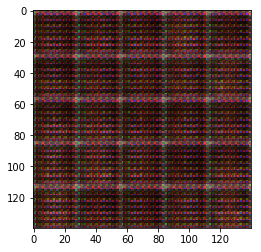

Epoch 1/1... Batch 110... Discriminator Loss: 1.0863... Generator Loss: 1.4705
Epoch 1/1... Batch 120... Discriminator Loss: 1.2190... Generator Loss: 0.7390
Epoch 1/1... Batch 130... Discriminator Loss: 1.0106... Generator Loss: 1.7911
Epoch 1/1... Batch 140... Discriminator Loss: 0.9582... Generator Loss: 1.2869
Epoch 1/1... Batch 150... Discriminator Loss: 0.9945... Generator Loss: 1.2200
Epoch 1/1... Batch 160... Discriminator Loss: 1.2644... Generator Loss: 0.7524
Epoch 1/1... Batch 170... Discriminator Loss: 1.0592... Generator Loss: 1.1474
Epoch 1/1... Batch 180... Discriminator Loss: 1.0876... Generator Loss: 1.0241
Epoch 1/1... Batch 190... Discriminator Loss: 1.3909... Generator Loss: 0.6822
Epoch 1/1... Batch 200... Discriminator Loss: 1.3467... Generator Loss: 0.7150


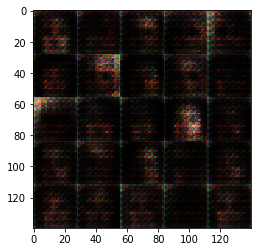

Epoch 1/1... Batch 210... Discriminator Loss: 1.1909... Generator Loss: 1.3802
Epoch 1/1... Batch 220... Discriminator Loss: 1.0732... Generator Loss: 1.4449
Epoch 1/1... Batch 230... Discriminator Loss: 1.0597... Generator Loss: 1.0678
Epoch 1/1... Batch 240... Discriminator Loss: 1.2118... Generator Loss: 0.7734
Epoch 1/1... Batch 250... Discriminator Loss: 1.2057... Generator Loss: 0.9995
Epoch 1/1... Batch 260... Discriminator Loss: 1.1172... Generator Loss: 0.9455
Epoch 1/1... Batch 270... Discriminator Loss: 1.0870... Generator Loss: 1.1255
Epoch 1/1... Batch 280... Discriminator Loss: 1.2376... Generator Loss: 0.9290
Epoch 1/1... Batch 290... Discriminator Loss: 1.0478... Generator Loss: 1.4338
Epoch 1/1... Batch 300... Discriminator Loss: 1.1855... Generator Loss: 0.9649


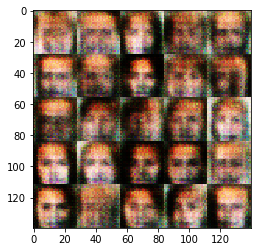

Epoch 1/1... Batch 310... Discriminator Loss: 1.0648... Generator Loss: 1.1512
Epoch 1/1... Batch 320... Discriminator Loss: 1.4565... Generator Loss: 0.6360
Epoch 1/1... Batch 330... Discriminator Loss: 1.2456... Generator Loss: 0.9443
Epoch 1/1... Batch 340... Discriminator Loss: 1.2912... Generator Loss: 1.2066
Epoch 1/1... Batch 350... Discriminator Loss: 1.1475... Generator Loss: 1.2461
Epoch 1/1... Batch 360... Discriminator Loss: 1.1339... Generator Loss: 1.0151
Epoch 1/1... Batch 370... Discriminator Loss: 1.0328... Generator Loss: 1.2671
Epoch 1/1... Batch 380... Discriminator Loss: 1.2146... Generator Loss: 0.8834
Epoch 1/1... Batch 390... Discriminator Loss: 1.3758... Generator Loss: 0.6791
Epoch 1/1... Batch 400... Discriminator Loss: 1.1137... Generator Loss: 1.2009


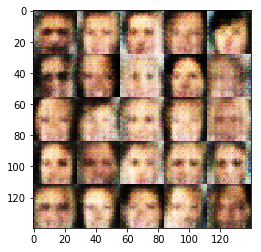

Epoch 1/1... Batch 410... Discriminator Loss: 1.2567... Generator Loss: 0.9349
Epoch 1/1... Batch 420... Discriminator Loss: 1.3441... Generator Loss: 0.9831
Epoch 1/1... Batch 430... Discriminator Loss: 1.1303... Generator Loss: 1.3518
Epoch 1/1... Batch 440... Discriminator Loss: 1.4628... Generator Loss: 0.8034
Epoch 1/1... Batch 450... Discriminator Loss: 1.8387... Generator Loss: 0.6803
Epoch 1/1... Batch 460... Discriminator Loss: 1.2900... Generator Loss: 0.8459
Epoch 1/1... Batch 470... Discriminator Loss: 1.2048... Generator Loss: 1.0853
Epoch 1/1... Batch 480... Discriminator Loss: 1.5043... Generator Loss: 0.8168
Epoch 1/1... Batch 490... Discriminator Loss: 1.3832... Generator Loss: 0.9958
Epoch 1/1... Batch 500... Discriminator Loss: 1.2583... Generator Loss: 0.8485


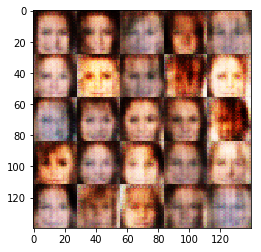

Epoch 1/1... Batch 510... Discriminator Loss: 1.1110... Generator Loss: 1.2003
Epoch 1/1... Batch 520... Discriminator Loss: 1.5815... Generator Loss: 0.8733
Epoch 1/1... Batch 530... Discriminator Loss: 1.4704... Generator Loss: 0.8073
Epoch 1/1... Batch 540... Discriminator Loss: 1.1864... Generator Loss: 0.8751
Epoch 1/1... Batch 550... Discriminator Loss: 1.3195... Generator Loss: 0.9081
Epoch 1/1... Batch 560... Discriminator Loss: 1.2521... Generator Loss: 1.0618
Epoch 1/1... Batch 570... Discriminator Loss: 1.2631... Generator Loss: 0.9169
Epoch 1/1... Batch 580... Discriminator Loss: 1.4333... Generator Loss: 0.8131
Epoch 1/1... Batch 590... Discriminator Loss: 1.3444... Generator Loss: 0.7894
Epoch 1/1... Batch 600... Discriminator Loss: 1.2834... Generator Loss: 1.0188


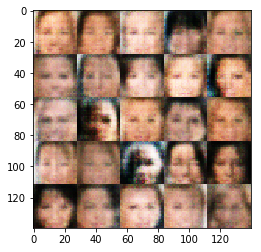

Epoch 1/1... Batch 610... Discriminator Loss: 1.3448... Generator Loss: 1.0408
Epoch 1/1... Batch 620... Discriminator Loss: 1.1760... Generator Loss: 0.9699
Epoch 1/1... Batch 630... Discriminator Loss: 1.3439... Generator Loss: 0.8232
Epoch 1/1... Batch 640... Discriminator Loss: 1.1638... Generator Loss: 0.9323
Epoch 1/1... Batch 650... Discriminator Loss: 1.2524... Generator Loss: 0.8315
Epoch 1/1... Batch 660... Discriminator Loss: 1.2012... Generator Loss: 1.1562
Epoch 1/1... Batch 670... Discriminator Loss: 1.2488... Generator Loss: 0.7847
Epoch 1/1... Batch 680... Discriminator Loss: 1.2845... Generator Loss: 1.0025
Epoch 1/1... Batch 690... Discriminator Loss: 1.2451... Generator Loss: 1.0024
Epoch 1/1... Batch 700... Discriminator Loss: 1.2868... Generator Loss: 0.7826


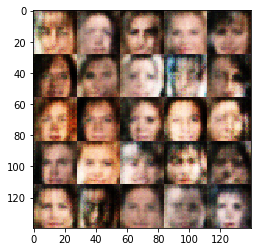

Epoch 1/1... Batch 710... Discriminator Loss: 1.2319... Generator Loss: 0.7890
Epoch 1/1... Batch 720... Discriminator Loss: 1.3597... Generator Loss: 0.8440
Epoch 1/1... Batch 730... Discriminator Loss: 1.3218... Generator Loss: 0.8939
Epoch 1/1... Batch 740... Discriminator Loss: 1.2583... Generator Loss: 1.0013
Epoch 1/1... Batch 750... Discriminator Loss: 1.2914... Generator Loss: 0.9150
Epoch 1/1... Batch 760... Discriminator Loss: 1.2624... Generator Loss: 0.7725
Epoch 1/1... Batch 770... Discriminator Loss: 1.4096... Generator Loss: 0.8084
Epoch 1/1... Batch 780... Discriminator Loss: 1.3218... Generator Loss: 0.7909
Epoch 1/1... Batch 790... Discriminator Loss: 1.2767... Generator Loss: 1.0010
Epoch 1/1... Batch 800... Discriminator Loss: 1.1625... Generator Loss: 1.1057


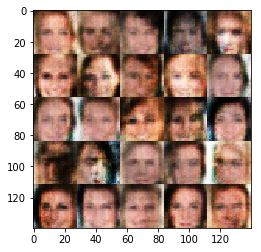

Epoch 1/1... Batch 810... Discriminator Loss: 1.2750... Generator Loss: 0.8968
Epoch 1/1... Batch 820... Discriminator Loss: 1.2241... Generator Loss: 0.9659
Epoch 1/1... Batch 830... Discriminator Loss: 1.2322... Generator Loss: 0.9065
Epoch 1/1... Batch 840... Discriminator Loss: 1.2794... Generator Loss: 1.0039
Epoch 1/1... Batch 850... Discriminator Loss: 1.2747... Generator Loss: 0.7360
Epoch 1/1... Batch 860... Discriminator Loss: 1.3313... Generator Loss: 0.7727
Epoch 1/1... Batch 870... Discriminator Loss: 1.3380... Generator Loss: 0.9927
Epoch 1/1... Batch 880... Discriminator Loss: 1.3334... Generator Loss: 0.9274
Epoch 1/1... Batch 890... Discriminator Loss: 1.2672... Generator Loss: 0.9844
Epoch 1/1... Batch 900... Discriminator Loss: 1.3894... Generator Loss: 0.7419


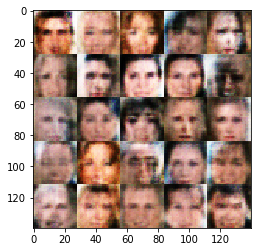

Epoch 1/1... Batch 910... Discriminator Loss: 1.3360... Generator Loss: 0.8072
Epoch 1/1... Batch 920... Discriminator Loss: 1.3256... Generator Loss: 1.0085
Epoch 1/1... Batch 930... Discriminator Loss: 1.4071... Generator Loss: 0.7327
Epoch 1/1... Batch 940... Discriminator Loss: 1.3464... Generator Loss: 0.9650
Epoch 1/1... Batch 950... Discriminator Loss: 1.3584... Generator Loss: 0.8175
Epoch 1/1... Batch 960... Discriminator Loss: 1.2980... Generator Loss: 0.9153
Epoch 1/1... Batch 970... Discriminator Loss: 1.3568... Generator Loss: 0.7234
Epoch 1/1... Batch 980... Discriminator Loss: 1.3703... Generator Loss: 0.8071
Epoch 1/1... Batch 990... Discriminator Loss: 1.2773... Generator Loss: 0.9211
Epoch 1/1... Batch 1000... Discriminator Loss: 1.2762... Generator Loss: 1.0091


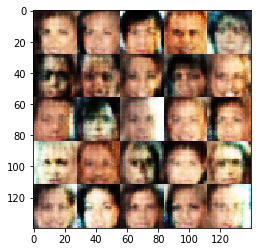

Epoch 1/1... Batch 1010... Discriminator Loss: 1.4042... Generator Loss: 0.8647
Epoch 1/1... Batch 1020... Discriminator Loss: 1.2740... Generator Loss: 0.8866
Epoch 1/1... Batch 1030... Discriminator Loss: 1.3030... Generator Loss: 0.8833
Epoch 1/1... Batch 1040... Discriminator Loss: 1.4356... Generator Loss: 1.0014
Epoch 1/1... Batch 1050... Discriminator Loss: 1.4704... Generator Loss: 0.8273
Epoch 1/1... Batch 1060... Discriminator Loss: 1.3144... Generator Loss: 0.9688
Epoch 1/1... Batch 1070... Discriminator Loss: 1.2022... Generator Loss: 0.8689
Epoch 1/1... Batch 1080... Discriminator Loss: 1.2916... Generator Loss: 0.8769
Epoch 1/1... Batch 1090... Discriminator Loss: 1.2609... Generator Loss: 1.0695
Epoch 1/1... Batch 1100... Discriminator Loss: 1.3328... Generator Loss: 0.7090


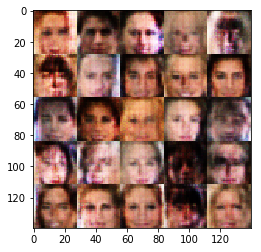

Epoch 1/1... Batch 1110... Discriminator Loss: 1.2860... Generator Loss: 0.7708
Epoch 1/1... Batch 1120... Discriminator Loss: 1.3127... Generator Loss: 0.7559
Epoch 1/1... Batch 1130... Discriminator Loss: 1.2025... Generator Loss: 0.9817
Epoch 1/1... Batch 1140... Discriminator Loss: 1.2287... Generator Loss: 0.7915
Epoch 1/1... Batch 1150... Discriminator Loss: 1.2633... Generator Loss: 1.0035
Epoch 1/1... Batch 1160... Discriminator Loss: 1.2734... Generator Loss: 0.9703
Epoch 1/1... Batch 1170... Discriminator Loss: 1.3050... Generator Loss: 0.9413
Epoch 1/1... Batch 1180... Discriminator Loss: 1.2463... Generator Loss: 0.9487
Epoch 1/1... Batch 1190... Discriminator Loss: 1.4585... Generator Loss: 0.7592
Epoch 1/1... Batch 1200... Discriminator Loss: 1.4030... Generator Loss: 0.8528


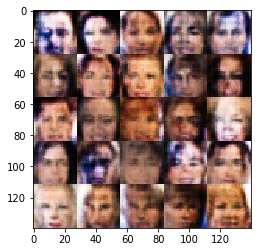

Epoch 1/1... Batch 1210... Discriminator Loss: 1.3669... Generator Loss: 0.7315
Epoch 1/1... Batch 1220... Discriminator Loss: 1.1807... Generator Loss: 0.9791
Epoch 1/1... Batch 1230... Discriminator Loss: 1.3818... Generator Loss: 0.8885
Epoch 1/1... Batch 1240... Discriminator Loss: 1.2046... Generator Loss: 0.9685
Epoch 1/1... Batch 1250... Discriminator Loss: 1.2699... Generator Loss: 0.8619
Epoch 1/1... Batch 1260... Discriminator Loss: 1.2365... Generator Loss: 0.8634
Epoch 1/1... Batch 1270... Discriminator Loss: 1.2315... Generator Loss: 0.8315
Epoch 1/1... Batch 1280... Discriminator Loss: 1.3138... Generator Loss: 0.8410
Epoch 1/1... Batch 1290... Discriminator Loss: 1.3335... Generator Loss: 0.8755
Epoch 1/1... Batch 1300... Discriminator Loss: 1.2016... Generator Loss: 0.9222


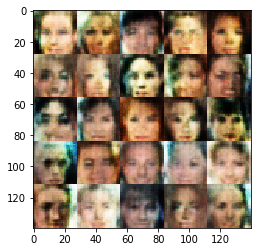

Epoch 1/1... Batch 1310... Discriminator Loss: 1.2096... Generator Loss: 0.9566
Epoch 1/1... Batch 1320... Discriminator Loss: 1.2692... Generator Loss: 0.9131
Epoch 1/1... Batch 1330... Discriminator Loss: 1.2503... Generator Loss: 0.9149
Epoch 1/1... Batch 1340... Discriminator Loss: 1.2382... Generator Loss: 1.0956
Epoch 1/1... Batch 1350... Discriminator Loss: 1.2311... Generator Loss: 0.9172
Epoch 1/1... Batch 1360... Discriminator Loss: 1.4112... Generator Loss: 0.7538
Epoch 1/1... Batch 1370... Discriminator Loss: 1.2351... Generator Loss: 0.8829
Epoch 1/1... Batch 1380... Discriminator Loss: 1.2033... Generator Loss: 0.9382
Epoch 1/1... Batch 1390... Discriminator Loss: 1.2943... Generator Loss: 0.8672
Epoch 1/1... Batch 1400... Discriminator Loss: 1.3852... Generator Loss: 0.7320


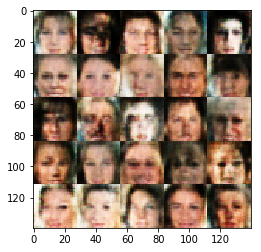

Epoch 1/1... Batch 1410... Discriminator Loss: 1.3581... Generator Loss: 0.8007
Epoch 1/1... Batch 1420... Discriminator Loss: 1.3481... Generator Loss: 0.8468
Epoch 1/1... Batch 1430... Discriminator Loss: 1.2038... Generator Loss: 0.9818
Epoch 1/1... Batch 1440... Discriminator Loss: 1.3017... Generator Loss: 0.8523
Epoch 1/1... Batch 1450... Discriminator Loss: 1.2850... Generator Loss: 0.8655
Epoch 1/1... Batch 1460... Discriminator Loss: 1.2870... Generator Loss: 0.8184
Epoch 1/1... Batch 1470... Discriminator Loss: 1.2606... Generator Loss: 1.0806
Epoch 1/1... Batch 1480... Discriminator Loss: 1.2063... Generator Loss: 0.8121
Epoch 1/1... Batch 1490... Discriminator Loss: 1.4197... Generator Loss: 0.7020
Epoch 1/1... Batch 1500... Discriminator Loss: 1.2815... Generator Loss: 0.8230


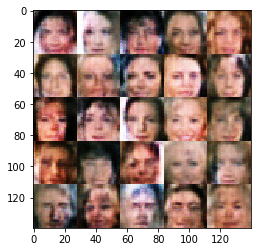

Epoch 1/1... Batch 1510... Discriminator Loss: 1.1767... Generator Loss: 0.8690
Epoch 1/1... Batch 1520... Discriminator Loss: 1.3299... Generator Loss: 0.9579
Epoch 1/1... Batch 1530... Discriminator Loss: 1.2516... Generator Loss: 0.8906
Epoch 1/1... Batch 1540... Discriminator Loss: 1.2369... Generator Loss: 0.9647
Epoch 1/1... Batch 1550... Discriminator Loss: 1.3737... Generator Loss: 0.8996
Epoch 1/1... Batch 1560... Discriminator Loss: 1.1991... Generator Loss: 0.9171
Epoch 1/1... Batch 1570... Discriminator Loss: 1.2225... Generator Loss: 0.9060
Epoch 1/1... Batch 1580... Discriminator Loss: 1.2114... Generator Loss: 1.2265
Epoch 1/1... Batch 1590... Discriminator Loss: 1.3833... Generator Loss: 0.7642
Epoch 1/1... Batch 1600... Discriminator Loss: 1.3788... Generator Loss: 0.7247


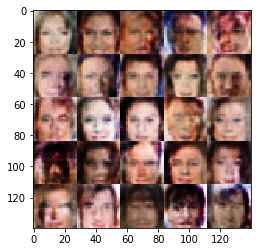

Epoch 1/1... Batch 1610... Discriminator Loss: 1.3503... Generator Loss: 0.6252
Epoch 1/1... Batch 1620... Discriminator Loss: 1.2880... Generator Loss: 0.7065
Epoch 1/1... Batch 1630... Discriminator Loss: 1.2117... Generator Loss: 0.9684
Epoch 1/1... Batch 1640... Discriminator Loss: 1.1087... Generator Loss: 1.0252
Epoch 1/1... Batch 1650... Discriminator Loss: 1.3579... Generator Loss: 0.7635
Epoch 1/1... Batch 1660... Discriminator Loss: 1.3471... Generator Loss: 0.7903
Epoch 1/1... Batch 1670... Discriminator Loss: 1.2663... Generator Loss: 0.7436
Epoch 1/1... Batch 1680... Discriminator Loss: 1.2760... Generator Loss: 0.8237
Epoch 1/1... Batch 1690... Discriminator Loss: 1.3660... Generator Loss: 0.7777
Epoch 1/1... Batch 1700... Discriminator Loss: 1.3134... Generator Loss: 0.6986


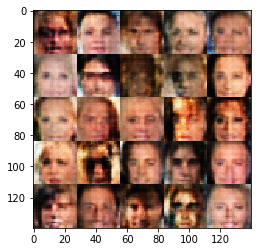

Epoch 1/1... Batch 1710... Discriminator Loss: 1.3913... Generator Loss: 0.8648
Epoch 1/1... Batch 1720... Discriminator Loss: 1.2194... Generator Loss: 0.7959
Epoch 1/1... Batch 1730... Discriminator Loss: 1.3954... Generator Loss: 0.7157
Epoch 1/1... Batch 1740... Discriminator Loss: 1.3646... Generator Loss: 0.6617
Epoch 1/1... Batch 1750... Discriminator Loss: 1.2235... Generator Loss: 0.9418
Epoch 1/1... Batch 1760... Discriminator Loss: 1.1598... Generator Loss: 1.0252
Epoch 1/1... Batch 1770... Discriminator Loss: 1.2589... Generator Loss: 0.8252
Epoch 1/1... Batch 1780... Discriminator Loss: 1.3243... Generator Loss: 0.7942
Epoch 1/1... Batch 1790... Discriminator Loss: 1.1600... Generator Loss: 1.0671
Epoch 1/1... Batch 1800... Discriminator Loss: 1.2324... Generator Loss: 0.9230


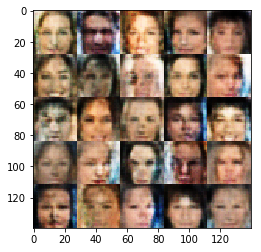

Epoch 1/1... Batch 1810... Discriminator Loss: 1.1909... Generator Loss: 1.1706
Epoch 1/1... Batch 1820... Discriminator Loss: 1.2754... Generator Loss: 0.8614
Epoch 1/1... Batch 1830... Discriminator Loss: 1.1820... Generator Loss: 1.0408
Epoch 1/1... Batch 1840... Discriminator Loss: 1.1847... Generator Loss: 0.9790
Epoch 1/1... Batch 1850... Discriminator Loss: 1.4415... Generator Loss: 0.6999
Epoch 1/1... Batch 1860... Discriminator Loss: 1.1758... Generator Loss: 0.7627
Epoch 1/1... Batch 1870... Discriminator Loss: 1.3554... Generator Loss: 0.9012
Epoch 1/1... Batch 1880... Discriminator Loss: 1.1893... Generator Loss: 0.8758
Epoch 1/1... Batch 1890... Discriminator Loss: 1.1427... Generator Loss: 1.3625
Epoch 1/1... Batch 1900... Discriminator Loss: 1.3989... Generator Loss: 0.7610


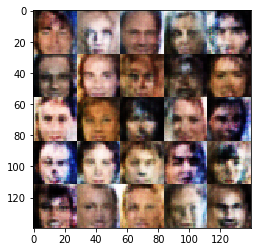

Epoch 1/1... Batch 1910... Discriminator Loss: 1.2081... Generator Loss: 0.8187
Epoch 1/1... Batch 1920... Discriminator Loss: 1.2757... Generator Loss: 0.8730
Epoch 1/1... Batch 1930... Discriminator Loss: 1.3063... Generator Loss: 0.7606
Epoch 1/1... Batch 1940... Discriminator Loss: 1.2724... Generator Loss: 0.9867
Epoch 1/1... Batch 1950... Discriminator Loss: 1.2624... Generator Loss: 0.9551
Epoch 1/1... Batch 1960... Discriminator Loss: 1.1826... Generator Loss: 0.8724
Epoch 1/1... Batch 1970... Discriminator Loss: 1.2410... Generator Loss: 1.0314
Epoch 1/1... Batch 1980... Discriminator Loss: 1.2263... Generator Loss: 0.8004
Epoch 1/1... Batch 1990... Discriminator Loss: 1.2418... Generator Loss: 0.8701
Epoch 1/1... Batch 2000... Discriminator Loss: 1.2896... Generator Loss: 0.7088


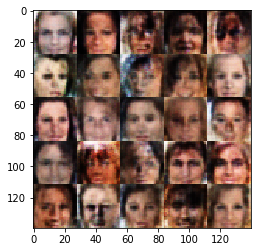

Epoch 1/1... Batch 2010... Discriminator Loss: 1.1762... Generator Loss: 0.8984
Epoch 1/1... Batch 2020... Discriminator Loss: 1.1765... Generator Loss: 0.9314
Epoch 1/1... Batch 2030... Discriminator Loss: 1.2316... Generator Loss: 0.7216
Epoch 1/1... Batch 2040... Discriminator Loss: 1.2562... Generator Loss: 0.7908
Epoch 1/1... Batch 2050... Discriminator Loss: 1.1581... Generator Loss: 1.0170
Epoch 1/1... Batch 2060... Discriminator Loss: 1.1031... Generator Loss: 1.0409
Epoch 1/1... Batch 2070... Discriminator Loss: 1.2856... Generator Loss: 0.8633
Epoch 1/1... Batch 2080... Discriminator Loss: 1.1979... Generator Loss: 0.9253
Epoch 1/1... Batch 2090... Discriminator Loss: 1.1103... Generator Loss: 0.9337
Epoch 1/1... Batch 2100... Discriminator Loss: 1.1905... Generator Loss: 1.0349


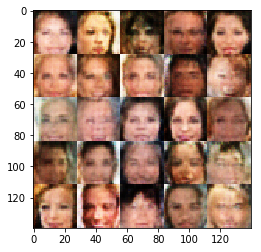

Epoch 1/1... Batch 2110... Discriminator Loss: 1.2122... Generator Loss: 1.0708
Epoch 1/1... Batch 2120... Discriminator Loss: 1.1939... Generator Loss: 0.9613
Epoch 1/1... Batch 2130... Discriminator Loss: 1.2452... Generator Loss: 0.8635
Epoch 1/1... Batch 2140... Discriminator Loss: 1.3070... Generator Loss: 0.7775
Epoch 1/1... Batch 2150... Discriminator Loss: 1.3464... Generator Loss: 0.8236
Epoch 1/1... Batch 2160... Discriminator Loss: 1.3000... Generator Loss: 0.8236
Epoch 1/1... Batch 2170... Discriminator Loss: 1.1734... Generator Loss: 1.0400
Epoch 1/1... Batch 2180... Discriminator Loss: 1.3683... Generator Loss: 0.7445
Epoch 1/1... Batch 2190... Discriminator Loss: 1.3297... Generator Loss: 0.8326
Epoch 1/1... Batch 2200... Discriminator Loss: 1.0981... Generator Loss: 1.0550


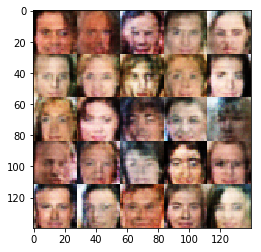

Epoch 1/1... Batch 2210... Discriminator Loss: 1.1866... Generator Loss: 1.1732
Epoch 1/1... Batch 2220... Discriminator Loss: 1.1288... Generator Loss: 0.8040
Epoch 1/1... Batch 2230... Discriminator Loss: 1.2957... Generator Loss: 0.7348
Epoch 1/1... Batch 2240... Discriminator Loss: 1.2908... Generator Loss: 0.7412
Epoch 1/1... Batch 2250... Discriminator Loss: 1.3642... Generator Loss: 0.8011
Epoch 1/1... Batch 2260... Discriminator Loss: 1.2327... Generator Loss: 0.7624
Epoch 1/1... Batch 2270... Discriminator Loss: 1.1988... Generator Loss: 0.9697
Epoch 1/1... Batch 2280... Discriminator Loss: 1.2514... Generator Loss: 1.0785
Epoch 1/1... Batch 2290... Discriminator Loss: 1.2335... Generator Loss: 1.1217
Epoch 1/1... Batch 2300... Discriminator Loss: 1.3495... Generator Loss: 0.7603


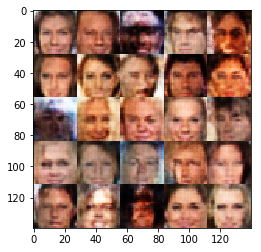

Epoch 1/1... Batch 2310... Discriminator Loss: 1.1986... Generator Loss: 0.7853
Epoch 1/1... Batch 2320... Discriminator Loss: 1.1337... Generator Loss: 1.2346
Epoch 1/1... Batch 2330... Discriminator Loss: 1.2919... Generator Loss: 0.7288
Epoch 1/1... Batch 2340... Discriminator Loss: 1.3672... Generator Loss: 0.7561
Epoch 1/1... Batch 2350... Discriminator Loss: 1.2923... Generator Loss: 0.6734
Epoch 1/1... Batch 2360... Discriminator Loss: 1.2413... Generator Loss: 0.9305
Epoch 1/1... Batch 2370... Discriminator Loss: 1.3022... Generator Loss: 0.7216
Epoch 1/1... Batch 2380... Discriminator Loss: 1.3450... Generator Loss: 0.6949
Epoch 1/1... Batch 2390... Discriminator Loss: 1.2042... Generator Loss: 0.9132
Epoch 1/1... Batch 2400... Discriminator Loss: 1.2026... Generator Loss: 1.0116


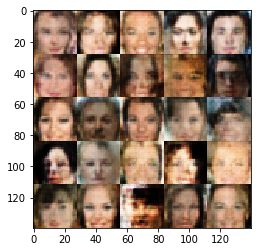

Epoch 1/1... Batch 2410... Discriminator Loss: 1.3854... Generator Loss: 0.6681
Epoch 1/1... Batch 2420... Discriminator Loss: 1.2452... Generator Loss: 1.0559
Epoch 1/1... Batch 2430... Discriminator Loss: 1.2284... Generator Loss: 0.8876
Epoch 1/1... Batch 2440... Discriminator Loss: 1.3385... Generator Loss: 0.8018
Epoch 1/1... Batch 2450... Discriminator Loss: 1.2327... Generator Loss: 0.9245
Epoch 1/1... Batch 2460... Discriminator Loss: 1.2877... Generator Loss: 0.6882
Epoch 1/1... Batch 2470... Discriminator Loss: 1.2749... Generator Loss: 0.7354
Epoch 1/1... Batch 2480... Discriminator Loss: 1.1992... Generator Loss: 1.1045
Epoch 1/1... Batch 2490... Discriminator Loss: 1.3055... Generator Loss: 0.6895
Epoch 1/1... Batch 2500... Discriminator Loss: 1.2287... Generator Loss: 0.8918


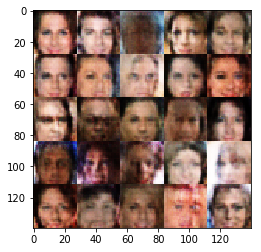

Epoch 1/1... Batch 2510... Discriminator Loss: 1.2342... Generator Loss: 0.7325
Epoch 1/1... Batch 2520... Discriminator Loss: 1.0996... Generator Loss: 1.0030
Epoch 1/1... Batch 2530... Discriminator Loss: 0.9795... Generator Loss: 1.3041
Epoch 1/1... Batch 2540... Discriminator Loss: 1.1428... Generator Loss: 0.9087
Epoch 1/1... Batch 2550... Discriminator Loss: 1.4152... Generator Loss: 0.6743
Epoch 1/1... Batch 2560... Discriminator Loss: 1.2394... Generator Loss: 0.8107
Epoch 1/1... Batch 2570... Discriminator Loss: 1.2002... Generator Loss: 0.9168
Epoch 1/1... Batch 2580... Discriminator Loss: 1.1916... Generator Loss: 1.2675
Epoch 1/1... Batch 2590... Discriminator Loss: 1.1137... Generator Loss: 1.1957
Epoch 1/1... Batch 2600... Discriminator Loss: 1.2569... Generator Loss: 0.7664


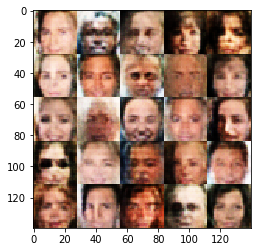

Epoch 1/1... Batch 2610... Discriminator Loss: 1.1920... Generator Loss: 0.7712
Epoch 1/1... Batch 2620... Discriminator Loss: 1.2204... Generator Loss: 0.7643
Epoch 1/1... Batch 2630... Discriminator Loss: 1.1424... Generator Loss: 1.0752
Epoch 1/1... Batch 2640... Discriminator Loss: 1.0670... Generator Loss: 1.0842
Epoch 1/1... Batch 2650... Discriminator Loss: 1.2155... Generator Loss: 0.8129
Epoch 1/1... Batch 2660... Discriminator Loss: 1.1101... Generator Loss: 1.0744
Epoch 1/1... Batch 2670... Discriminator Loss: 1.3169... Generator Loss: 1.0867
Epoch 1/1... Batch 2680... Discriminator Loss: 1.6026... Generator Loss: 0.4360
Epoch 1/1... Batch 2690... Discriminator Loss: 1.2383... Generator Loss: 0.8685
Epoch 1/1... Batch 2700... Discriminator Loss: 1.4925... Generator Loss: 0.6308


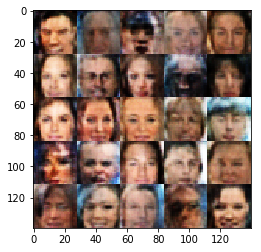

Epoch 1/1... Batch 2710... Discriminator Loss: 1.3704... Generator Loss: 0.8339
Epoch 1/1... Batch 2720... Discriminator Loss: 1.2522... Generator Loss: 0.8597
Epoch 1/1... Batch 2730... Discriminator Loss: 1.2870... Generator Loss: 0.7214
Epoch 1/1... Batch 2740... Discriminator Loss: 1.2554... Generator Loss: 0.8301
Epoch 1/1... Batch 2750... Discriminator Loss: 1.1667... Generator Loss: 0.8072
Epoch 1/1... Batch 2760... Discriminator Loss: 1.2652... Generator Loss: 0.9566
Epoch 1/1... Batch 2770... Discriminator Loss: 1.1838... Generator Loss: 1.0087
Epoch 1/1... Batch 2780... Discriminator Loss: 1.2976... Generator Loss: 0.8990
Epoch 1/1... Batch 2790... Discriminator Loss: 1.1150... Generator Loss: 0.9320
Epoch 1/1... Batch 2800... Discriminator Loss: 1.1951... Generator Loss: 0.8055


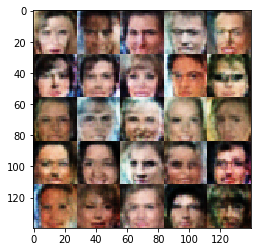

Epoch 1/1... Batch 2810... Discriminator Loss: 1.0623... Generator Loss: 0.9724
Epoch 1/1... Batch 2820... Discriminator Loss: 1.2811... Generator Loss: 0.7702
Epoch 1/1... Batch 2830... Discriminator Loss: 1.2794... Generator Loss: 0.7339
Epoch 1/1... Batch 2840... Discriminator Loss: 1.3404... Generator Loss: 0.6762
Epoch 1/1... Batch 2850... Discriminator Loss: 1.2243... Generator Loss: 0.8576
Epoch 1/1... Batch 2860... Discriminator Loss: 1.1776... Generator Loss: 1.1127
Epoch 1/1... Batch 2870... Discriminator Loss: 1.1801... Generator Loss: 1.0190
Epoch 1/1... Batch 2880... Discriminator Loss: 1.1504... Generator Loss: 0.9508
Epoch 1/1... Batch 2890... Discriminator Loss: 1.2815... Generator Loss: 0.9364
Epoch 1/1... Batch 2900... Discriminator Loss: 1.3148... Generator Loss: 0.6470


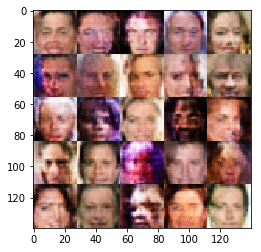

Epoch 1/1... Batch 2910... Discriminator Loss: 1.1250... Generator Loss: 0.9633
Epoch 1/1... Batch 2920... Discriminator Loss: 1.1484... Generator Loss: 1.0416
Epoch 1/1... Batch 2930... Discriminator Loss: 1.2472... Generator Loss: 0.9480
Epoch 1/1... Batch 2940... Discriminator Loss: 1.0769... Generator Loss: 1.0505
Epoch 1/1... Batch 2950... Discriminator Loss: 1.4068... Generator Loss: 0.6695
Epoch 1/1... Batch 2960... Discriminator Loss: 1.4121... Generator Loss: 0.7644
Epoch 1/1... Batch 2970... Discriminator Loss: 1.1033... Generator Loss: 1.0425
Epoch 1/1... Batch 2980... Discriminator Loss: 1.0299... Generator Loss: 1.1476
Epoch 1/1... Batch 2990... Discriminator Loss: 1.2808... Generator Loss: 0.7209
Epoch 1/1... Batch 3000... Discriminator Loss: 1.1151... Generator Loss: 0.8345


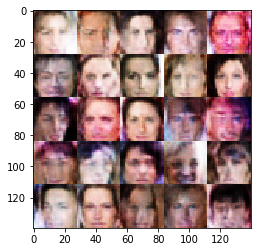

Epoch 1/1... Batch 3010... Discriminator Loss: 1.1196... Generator Loss: 0.9883
Epoch 1/1... Batch 3020... Discriminator Loss: 1.2222... Generator Loss: 0.7996
Epoch 1/1... Batch 3030... Discriminator Loss: 1.3025... Generator Loss: 0.8601
Epoch 1/1... Batch 3040... Discriminator Loss: 1.1575... Generator Loss: 0.8594
Epoch 1/1... Batch 3050... Discriminator Loss: 1.1330... Generator Loss: 1.0113
Epoch 1/1... Batch 3060... Discriminator Loss: 1.1808... Generator Loss: 1.1280
Epoch 1/1... Batch 3070... Discriminator Loss: 1.1406... Generator Loss: 1.0064
Epoch 1/1... Batch 3080... Discriminator Loss: 1.1490... Generator Loss: 0.9217
Epoch 1/1... Batch 3090... Discriminator Loss: 1.3136... Generator Loss: 0.7331
Epoch 1/1... Batch 3100... Discriminator Loss: 1.1931... Generator Loss: 0.8914


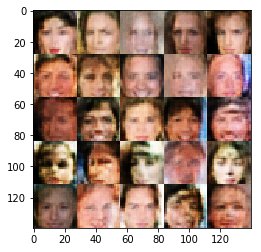

Epoch 1/1... Batch 3110... Discriminator Loss: 1.2350... Generator Loss: 0.9192
Epoch 1/1... Batch 3120... Discriminator Loss: 1.1502... Generator Loss: 0.9469
Epoch 1/1... Batch 3130... Discriminator Loss: 1.0600... Generator Loss: 1.1223
Epoch 1/1... Batch 3140... Discriminator Loss: 1.2156... Generator Loss: 0.9680
Epoch 1/1... Batch 3150... Discriminator Loss: 1.3097... Generator Loss: 0.8547
Epoch 1/1... Batch 3160... Discriminator Loss: 1.0697... Generator Loss: 1.0862


In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.